# **Reconocimiento de Patrones - Investigación Corta 2**
# Ing. Daniel Kohkemper

## Introducción

En este notebook se escoge un conjunto de datos para el análisis de diferentes métodos de aprendizaje supervisado, para poder cuantificar y comparar la efectividad de cada método en la clasificación de las clases del conjunto de datos. Los métodos que se van a comprobar son:

1. k-Nearest Neighbors (kNN)
2. Linear Regression
3. Support Vector Machines (SVM)
4. Decision Trees
5. TBD
6. AdaBoost (método de ensamble)

Se explicarán los detalles del conjunto de datos elegido y los resultados generales de cada método así como una discusión de cuál se desempaña mejor.

## Dataset

Para esta investigación se utiliza el dataset "Wine Data Set", encontrado en el repositorio de UCI [1], el cual es el resultado de un análisis de tres vinos desarrollados en la misma región de Italia pero de diferentes productores. El análisis determina las cantidades de 13 constituyentes, los cuales son en inglés:

1. Alcohol 
2. Malic acid 
3. Ash 
4. Alcalinity of ash 
5. Magnesium 
6. Total phenols 
7. Flavanoids 
8. Nonflavanoid phenols 
9. Proanthocyanins 
10. Color intensity 
11. Hue 
12. OD280/OD315 of diluted wines 
13. Proline

Existen diversas publicaciones que citan este dataset, por lo que la posibilidad de comparar los resultados con otros trabajos es amplia. A continuación se realizará el procesamiento del dataset así como la implementación de cada método mencionado anteriormente.

## Métricas de desempeño

Para más detalles sobre las diferentes métricas de desempeño, se recomienda consultar [7].

## Preprocesamiento y visualización del dataset

Aquí se importan las bibliotecas necesarias para el resto del trabajo, así como se carga también el dataset desde el URL del mismo y se eliminan las muestras que sean necesarias para limpiar los datos.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#from sklearn.decomposition import PCA
#from sklearn import preprocessing
#from sklearn.model_selection import train_test_split
#import matplotlib.pyplot as plt
#from IPython.display import Image
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.model_selection import ShuffleSplit
#from sklearn.preprocessing import scale
#from sklearn import datasets, linear_model

# Se apagan los warnings para evitar las alertas de posibles cambios de versión en Python3
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

# URL address of data set
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"

# Define header of dataset, obtain this information from dataset information
header = ['class', 'alcohol', 'malic acid', 'ash', 'alcalinity of ash', 'magnesium', 'total phenols', 'flavanoids', 'nonflavanoid phenols', 'Proanthocyanins', 'color intensity', 'hue', 'OD280/OD315 of diluted wines', 'proline']

# load dataset as csv file
df = pd.read_csv(url, names=header)

# if dataset has '?' in it, convert these into NaN
df = df.replace('?', np.nan)
# drop the NaN
df = df.dropna(axis=0, how="any")

# Print some values of the data set
df.head(5)

,class,alcohol,malic acid,ash,alcalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,Proanthocyanins,color intensity,hue,OD280/OD315 of diluted wines,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


A continuación se muestra un histograma en el cual se observa la variación de cada atributo del dataset. Cabe mencionar que distintos atributos pueden tener diferentes ordenes de magnitud en su variación.

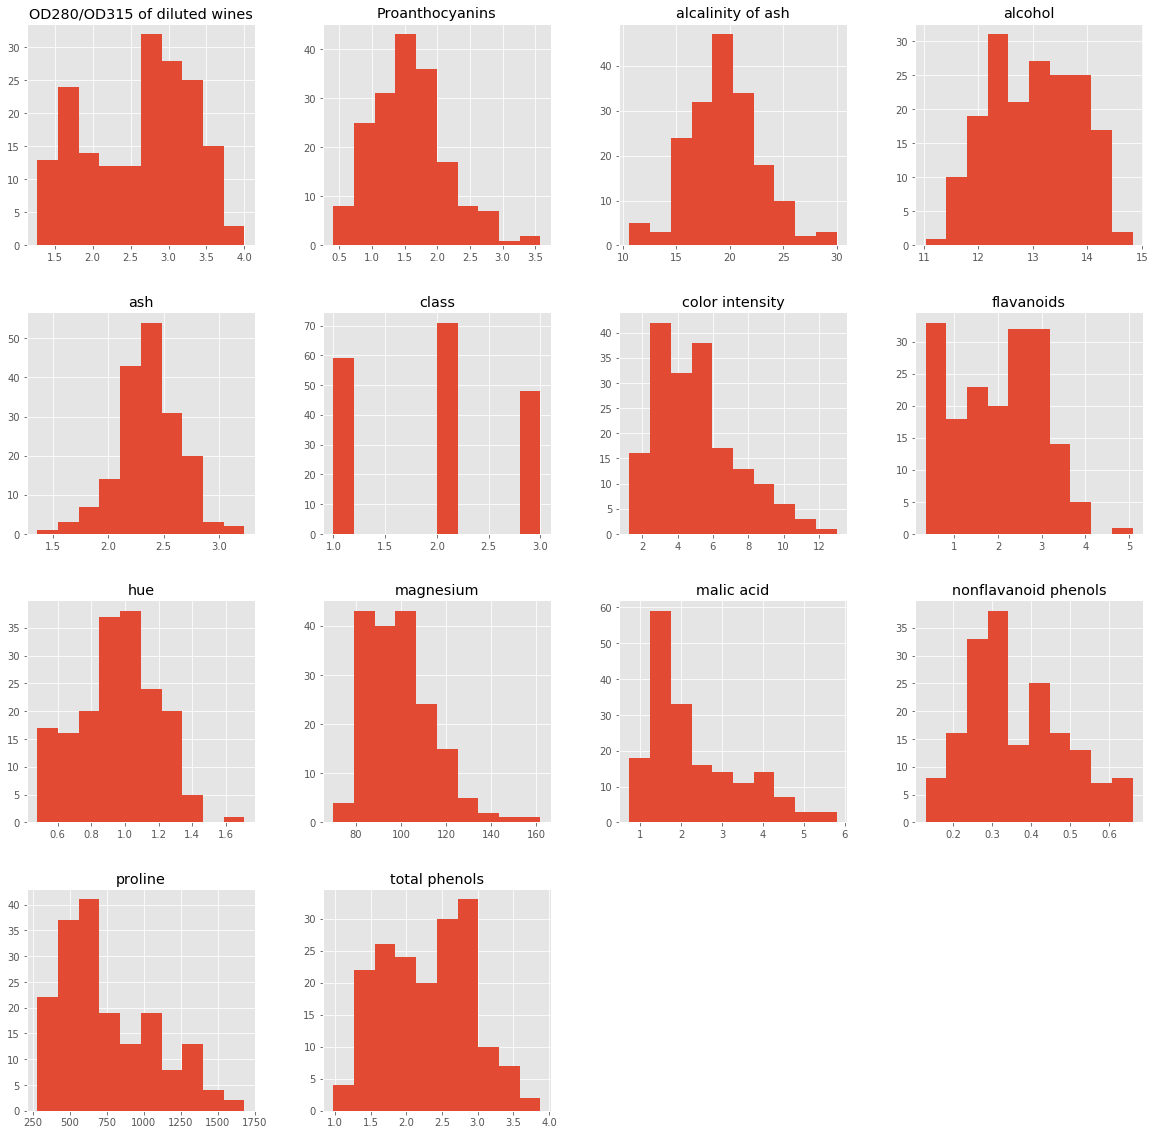

In [2]:
%matplotlib inline
#import matplotlib.pyplot as plt
plt.style.use('ggplot')
pd.DataFrame.hist(df, figsize = [20,20]);

## Partición del set de entrenamiento y prueba

Para poder implementar los modelos de aprendizaje supervisado, es necesario generar primeramente un set de datos de entrenamiento y de prueba [2][3].

In [3]:
from sklearn.model_selection import train_test_split

# Make a list of features only
features = ['alcohol', 'malic acid', 'ash', 'alcalinity of ash', 'magnesium', 'total phenols', 'flavanoids', 'nonflavanoid phenols', 'Proanthocyanins', 'color intensity', 'hue', 'OD280/OD315 of diluted wines', 'proline']

# Separate features from class(es)
input_features = df.loc[:,features].values
output_class   = df.loc[:,['class']].values
# Squeeze output into one single column
output_class = output_class.ravel()

# Separate data intro training and test sets
x_train, x_test, y_train, y_test = train_test_split(input_features, output_class, test_size=0.20, random_state=50)

A continuación se procede a implementar los métodos señalados anteriormente.

## 1. k-Nearest Neighbors

Este algoritmo clasifica una muestra de acuerdo a sus k vecinos más próximos, en donde este valor puede ser variado acordemente. En la siguiente figura [4] si k es 3, se clasifica la muestra como triángulo, en cambio si *k* es 5, se clasifica la muestra como cuadrado.

![bla](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/knn.png)

Para generar un modelo, es necesario primeramente separar los datos en un conjunto de entrenamiento y otro de prueba. Para esto es necesario crear unas nuevas listas, donde una contenga únicamente los atributos (*features*) y la otra contenga la o las clases. Usualmente, para este propósito se destina un 80% de las muestras para entrenamiento y 20% para pruebas, aunque es posible utilizar de igual manera 25% y 75%. Con valores menores a 20% o mayores a 30% para el conjunto de prueba, el puntaje de certeza empeora.

Después de haber separado el conjunto de datos en entrenamiento y prueba, es necesario generar el modelo kNN mediante el método `neighbors.KNeighborsClassifier`, en el cual se pueden ajustar los parámetros del algoritmo. Para visualizar los mismos, es necesario invocar a `neighbors.get_params`. Finalmente se ajusta el modelo con los datos de entrenamiento mediante `neighbors.fit`, con el cual se puede observar el puntaje de certeza con `neighbors.score`.

In [4]:
from sklearn import neighbors

# Generate kNN model
knn = neighbors.KNeighborsClassifier(n_neighbors = 4)
# Fit the model using x_train as training data and y_train as target values
knn_model_1 = knn.fit(x_train, y_train)

# Print accuracy scores
print('k-NN accuracy for train set: %f' % knn_model_1.score(x_train, y_train))
print('k-NN accuracy for test set: %f'  % knn_model_1.score(x_test, y_test))

# Get parameters of model
knn.get_params()

k-NN accuracy for train set: 0.816901
k-NN accuracy for test set: 0.694444


{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 4,
 'p': 2,
 'weights': 'uniform'}

Es posible además observar un reporte de otras métricas de certeza. Cabe mencionar que para este caso, la métrica del set de entrenamiento es mayor que la del set de prueba.

In [5]:
from sklearn.metrics import classification_report

y_true, y_pred = y_train, knn_model_1.predict(x_train)
print(classification_report(y_true, y_pred))

y_true, y_pred = y_test, knn_model_1.predict(x_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.93      0.91      0.92        46
           2       0.79      0.81      0.80        57
           3       0.72      0.72      0.72        39

   micro avg       0.82      0.82      0.82       142
   macro avg       0.81      0.81      0.81       142
weighted avg       0.82      0.82      0.82       142

              precision    recall  f1-score   support

           1       0.90      0.69      0.78        13
           2       0.65      0.93      0.76        14
           3       0.50      0.33      0.40         9

   micro avg       0.69      0.69      0.69        36
   macro avg       0.68      0.65      0.65        36
weighted avg       0.70      0.69      0.68        36



Es posible realizar varias iteraciones de este código anterior [5], para obtener así obtener métricas para diversos valores de k y así evaluar y ajustar el modelo al k más óptimo.

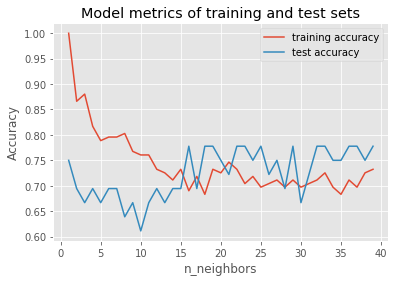

In [6]:
from sklearn.neighbors import KNeighborsClassifier

training_accuracy = []
test_accuracy = []

neighbors_settings = range(1, 40)

for n_neighbors in neighbors_settings:
    # se construye el modelo de clasificacion
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(x_train, y_train)
    # se almacena el "training set accuracy"
    training_accuracy.append(clf.score(x_train, y_train))
    # se almacena la "generalization accuracy"
    test_accuracy.append(clf.score(x_test, y_test))

# Plot results
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.title("Model metrics of training and test sets")
plt.legend()

Para este conjunto de datos en particular y el algortimo KNN, se observa que la métrica para el set de prueba es óptima para valores de k entre 15 y 40.

Es posible además escalar los atributos para obtener un mejor rendimiento en el algoritmo de clasificación.

In [7]:
from sklearn.preprocessing import scale

# Scale input features
input_feat_scaled = scale(input_features)
# Split features into train and test sets
Xs_train, Xs_test, y_train, y_test = train_test_split(input_feat_scaled, output_class, test_size=0.2, random_state=50)
# Fit model with new scaled training set
knn_model_2 = knn.fit(Xs_train, y_train)

print('k-NN score for training set: %f' % knn_model_2.score(Xs_train, y_train))
print('k-NN score for test set:     %f' % knn_model_2.score(Xs_test, y_test))

y_true, y_pred = y_test, knn_model_2.predict(Xs_test)

print(classification_report(y_true, y_pred))

k-NN score for training set: 0.978873
k-NN score for test set:     0.944444
              precision    recall  f1-score   support

           1       0.93      1.00      0.96        13
           2       1.00      0.86      0.92        14
           3       0.90      1.00      0.95         9

   micro avg       0.94      0.94      0.94        36
   macro avg       0.94      0.95      0.94        36
weighted avg       0.95      0.94      0.94        36



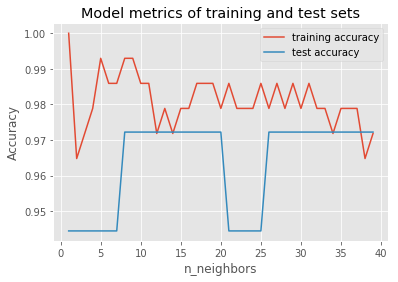

In [8]:
from sklearn.neighbors import KNeighborsClassifier

training_accuracy = []
test_accuracy = []

neighbors_settings = range(1, 40)

for n_neighbors in neighbors_settings:
    # Generate kNN model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    # Fit model
    clf.fit(Xs_train, y_train)
    # Calculate training score
    training_accuracy.append(clf.score(Xs_train, y_train))
    # Calculate test score
    test_accuracy.append(clf.score(Xs_test, y_test))

# Plot results
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.title("Model metrics of training and test sets")
plt.legend()

De aquí se observa que al escalar los datos, se aumenta la precisión del modelo.

## 2. Linear Regression

El concepto de regresión en general indica que se intenta predecir una variable independiente mediante una serie de variables independientes. En particular, la regresión lineal es un modelo estadístico que examina la relación lineal entre dos o más variables, para lo cual el proceso se llama Regresión Lineal Simple o Regresión Lineal Múltiple [6].

El objetivo de la regresión lineal es encontrar una línea recta que se ajuste mejor a los datos de entrada, con lo cual puede ser posible posteriormente predecir nuevos valores, asumiendo que la relación es lineal en ese rango y que no habrán otras variables que cambien las condiciones del modelo.

En la siguiente figura [6] se observa el proceso de la regresión lineal, en donde se intenta minimizar la distancia de cada muestra a la línea de mejor ajuste.

![](https://cdn-images-1.medium.com/max/800/1*A71zTD6_QqUzLhMKj1Rgiw.png)

En Python, la implementación de la regresión lineal es bastante simple y directa. Inicialmente, es necesario contar con un set de datos de entrenamiento y prueba, cosa que fue realizada anteriormente. Seguidamente se genera el modelo mediante `linear_model.LinearRegression()`, se entrena el algoritmo con los datos de entrenamiento mediante `model = lm.fit(x_train, y_train)` y se obtienen las prediciones con el set de datos de prueba con `predictions = lm.predict(x_test)`.  Finalmente, es posible obtener la métrica del modelo y graficar las predicciones con respecto al valor verdadero.

Training Score: 0.900381276442989
Test Score: 0.8909868692294324


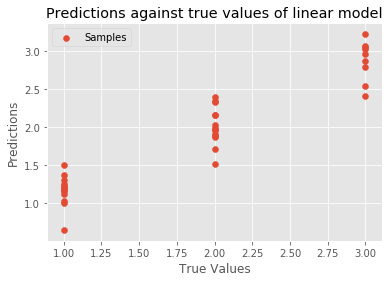

In [9]:
from sklearn import datasets, linear_model

# Generate linear model
lm = linear_model.LinearRegression()
# Fit the model using x_train as training data and y_train as target values
model = lm.fit(x_train, y_train)
# Predict the output with the test set as input
predictions = lm.predict(x_test)

print ("Training Score:", model.score(x_train, y_train))
print ("Test Score:", model.score(x_test, y_test))

## The line / model
plt.scatter(y_test, predictions, label="Samples")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Predictions against true values of linear model")
plt.legend(loc='upper left')
plt.grid(b=1, which='major', axis='both')
plt.show()

En la gráfica anterior no se observa exactamente una línea de mejor ajuste o una relación lineal en los resultados. La razón se debe a que la variable de salida no es continua, sino discreta, y puede resultar en valores de 1, 2, ó 3, que representan los diferentes productores de vino de la muestra.

Sin embargo, el modelo lineal, que en este caso tiene múltiples valores de salida, se ajusta bastante bien ya que se obtuvo un puntaje de 0.89 para el set de prueba.

## 3. Support Vector Machines

El algoritmo de Support Vector Machines (SVM) permite separar datos en dos dimensiones, pero se diferencia de los otros algoritmos en el que escoge el umbral de decisión de tal manera que se maximice la distancia de las muestras al umbral, como se observa en la siguiente figura [9]:

![](https://s3.amazonaws.com/stackabuse/media/implementing-svm-kernel-svm-python-scikit-learn-2.jpg)

Las muestras que forman parte de los umbrales son llamadas *support vectors*. El algoritmo se encarga de optimizar la línea que separa las muestras del manera que se minimice el error mediante el uso de matemática compleja.

La forma más simple de SVM es la lineal, aunque es posible utilizar diferentes *kernels* para datos no linealmente separables. Existen por ejemplo el *kernel* polinomail, gaussiano y sigmoide.

### Linear Kernel

Para utilizar el algoritmo SVM, si sigue la forma que se ha venido explicando para los otros algoritmos; se invoca al modelo, se ajustan los datos de entrenamiento y se predicen luego las salidas con el set de prueba. Finalmente es posible evaluar las métricas del algoritmo u observar la matriz de confusión.

Este método posee dos parámetros importantes que pueden ser ajustados [10]. Primeramente `gamma`, que define qué tan tanto influencia un dato en particular. Valores bajos significa 'lejos' y valores bajos significa 'cercano', en referencia al umbral de decisión. Otra interpretación puede ser el inverso del radio de influencia de muestras seleccionadas como *support vectors*.

El valor `C` realiza un compromiso entre la correcta clasificación de muestras contra la maximización del margen de decisión. Para valores altos, se aceptará un menor margen si la función de decisión es mejor en clasificar todos los puntos de entrenamiento correctamente. Un valor menor implicará una función de decisión más simple.

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

# Generate linear model
svclassifier = SVC(kernel='linear', C=100.0, gamma=0.1)
# Fit the model using x_train as training data and y_train as target values
svclassifier.fit(x_train, y_train)
# Predict the output with the test set as input
y_pred = svclassifier.predict(x_test)

print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

[[13  0  0]
 [ 1 13  0]
 [ 0  0  9]]
              precision    recall  f1-score   support

           1       0.93      1.00      0.96        13
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00         9

   micro avg       0.97      0.97      0.97        36
   macro avg       0.98      0.98      0.98        36
weighted avg       0.97      0.97      0.97        36

Accuracy: 0.9722222222222222


### Polynomial Kernel

Para el *kernel* polinomial, es necesario indicar `kernel='poly'` y el grado del polinomio mediante `degree=7`.

In [11]:
# Generate polynomial model
svclassifier = SVC(kernel='poly', degree=7, gamma='auto')  
# Fit the model using x_train as training data and y_train as target values
svclassifier.fit(x_train, y_train)
# Predict the output with the test set as input
y_pred = svclassifier.predict(x_test)

print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

[[12  1  0]
 [ 0 14  0]
 [ 0  1  8]]
              precision    recall  f1-score   support

           1       1.00      0.92      0.96        13
           2       0.88      1.00      0.93        14
           3       1.00      0.89      0.94         9

   micro avg       0.94      0.94      0.94        36
   macro avg       0.96      0.94      0.94        36
weighted avg       0.95      0.94      0.94        36

Accuracy: 0.9444444444444444


### Gaussian Kernel

Para el *kernel* gaussiano, es necesario indicar `kernel='rbf'`.

In [12]:
# Generate gaussian model
svclassifier = SVC(kernel='rbf', gamma='auto')  
# Fit the model using x_train as training data and y_train as target values
svclassifier.fit(x_train, y_train)
# Predict the output with the test set as input
y_pred = svclassifier.predict(x_test)

print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

[[ 2 11  0]
 [ 0 14  0]
 [ 0  8  1]]
              precision    recall  f1-score   support

           1       1.00      0.15      0.27        13
           2       0.42      1.00      0.60        14
           3       1.00      0.11      0.20         9

   micro avg       0.47      0.47      0.47        36
   macro avg       0.81      0.42      0.35        36
weighted avg       0.78      0.47      0.38        36

Accuracy: 0.4722222222222222


### Sigmoid Kernel

Para el *kernel* gaussiano, es necesario indicar `kernel='sigmoid'`.

In [13]:
# Generate sigmoid model
svclassifier = SVC(kernel='sigmoid', gamma='auto')
# Fit the model using x_train as training data and y_train as target values
svclassifier.fit(x_train, y_train)
# Predict the output with the test set as input
y_pred = svclassifier.predict(x_test)

print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


[[ 0 13  0]
 [ 0 14  0]
 [ 0  9  0]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        13
           2       0.39      1.00      0.56        14
           3       0.00      0.00      0.00         9

   micro avg       0.39      0.39      0.39        36
   macro avg       0.13      0.33      0.19        36
weighted avg       0.15      0.39      0.22        36

Accuracy: 0.3888888888888889


## 4. Decision Trees

Un árbol de decisión es un diagrama de flujo en forma de árbol, en donde un nodo interno representa un atributo, la rama representa una regla para una decisión  y cada hoja representa el resultado de la regla, como se observa a continuación [11]:

![](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1545934190/1_r5ikdb.png)

La clasificación de datos se realiza mediante los valores de los atributos y haciendo preguntas 'if-else'. La estructura del árbol puede ser tan simple o pequeña, o compleja como se desee, mediante la limitación de crecimiento del mismo. Es más favorable tener árboles pequeños y balanceados, ya que su interpretación es más simple e intuitiva.

El uso del algoritmo sigue los mismos pasos de los algoritmos anteriores, en donde se invoca al modelo, se ajustan los datos de entrenamiento y se predicen las salidas del conjunto de prueba.

Existen diversas variables que pueden ser ajustadas, como por ejemplo `max_depth` que indica la profundidad máxima del árbol o `min_samples_split` que indica la cantidad mínima de muestras necesarias para partir un nodo interno.


In [14]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state=0)
decision_tree.fit(x_train, y_train)

print("Accuracy on training set: {:.3f}".format(decision_tree.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(decision_tree.score(x_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.944


In [15]:
decision_tree = DecisionTreeClassifier(max_depth=3, random_state=0)
decision_tree.fit(x_train, y_train)

print("Accuracy on training set: {:.3f}".format(decision_tree.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(decision_tree.score(x_test, y_test)))

Accuracy on training set: 0.993
Accuracy on test set: 0.944


In [16]:
decision_tree = DecisionTreeClassifier(min_samples_split=5, random_state=0)
decision_tree.fit(x_train, y_train)

print("Accuracy on training set: {:.3f}".format(decision_tree.score(x_train, y_train)))
print("Accuracy on test set: {:.3f}".format(decision_tree.score(x_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.944


Mediante el método `decision_tree.feature_importances_` se puede imprimir un coeficiente de importancia de los atributos escogidos para realizar la clasificación. Algunos aparecen en cero, lo que indica que no fueron utilizados para la calificación o bien no aportaban información útil para la clasificación. Deben ser leídos junto con arreglo que guarda los nombres de los atributos en el mismo orden. Para este ejemplo en particular, los atributos importantes son: color intensity, proline, flavanoids y malic acid.

In [17]:
print("Feature importances:\n{}".format(decision_tree.feature_importances_))

Feature importances:
[0.         0.01901223 0.         0.         0.         0.
 0.4113604  0.         0.         0.40155113 0.02085404 0.
 0.14722219]


Es posible además graficar el árbol generado, en el cual se puede interpretar varios datos. Primeramente, aparece arriba al atributo con el cuál se está realizando la partición de muestras, así como la cantidad de muestras que hay en ese punto, el coeficiente gini y la clasificación de clase que se hace en ese punto.

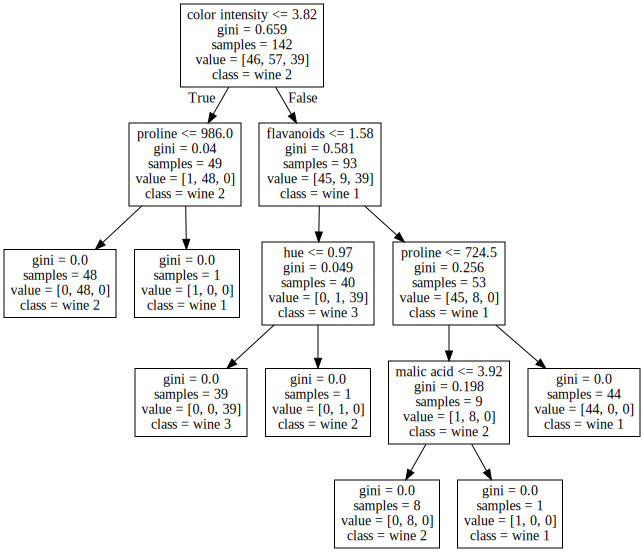

In [18]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(decision_tree, out_file=None)
graph = graphviz.Source(dot_data) 
#graph.render("decision_tree") 

dot_data = tree.export_graphviz(decision_tree, \
                                out_file=None,
                               feature_names = features,\
                               class_names = ["wine 1", "wine 2", "wine 3"],\
                               label = 'all') 
graph = graphviz.Source(dot_data)  
graph

## 5. Linear Discriminant Analysis

El algoritmo de Análisis Discriminante Lineal (LDA) encuentra la combinación lineal de atributos que clasifican dos o más clases de un objeto. Esta combinación resultante puede ser utilizada como un clasificador lineal o para reducir la dimensionalidad previo a una clasificación [12].

Es posible variar la cantidad de componentes con `n_components` y utilizar diferentes enfoques de solucionador con `solver`, de los cuales se puede escoger Singular Value Decomposition (svd), Least Squares solution (lsqr) o Eigenvalue decomposition (eigen).

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Generate SVD model
lda = LDA(n_components=2, solver='svd')  
# Fit test data
model = lda.fit(x_train, y_train)
# Predict the response
y_pred = model.predict(x_test)

# Se evalua la precisión
print("Test Accuracy:", model.score(x_test, y_test))

Test Accuracy: 1.0


In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Generate LSQR model
lda = LDA(n_components=2, solver='lsqr')
# Fit test data
model = lda.fit(x_train, y_train)
# Predict the response
y_pred = model.predict(x_test)

# Se evalua la precisión
print("Test Accuracy:", model.score(x_test, y_test))

Test Accuracy: 1.0


In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Generate Eigenvalues model
lda = LDA(n_components=2, solver='eigen')  
# Fit test data
model = lda.fit(x_train, y_train)

# predict the response
y_pred = model.predict(x_test)

# Se evalua la precisión
print("Test Accuracy:", model.score(x_test, y_test))

Test Accuracy: 0.9722222222222222


## Métodos de ensamble

En general, existen diversos enfoques para los algoritmos de ensamble, que se explican a continuación;

### 1. Bagging (agregación de bootstrap)
Combina múltiples modelos para reducir la varianza de los estimados. Aquí se generan nuevos conjuntos de entrenamiento, que son promediados para regresión y para clasificación se realiza una votación.

### 2. Boosting
Este método reduce el sesgo y varianza, siguiendo el objetivo de convertir un clasificador débil en uno robusto, mediante el uso de diferentes pesos en las predicciones de cada clasificador.

### 2. Stacking
Este método genera un nuevo conjunto de datos a partir de diversos modelos de clasificación, que sirve de entrada para un método de clasificación final.

## 6. Adaboost

El algoritmo Adaboost es parte de la categoría de algoritmos de ensamble, que consiste en la combinación de diversos clasificadores con bajo desempeño para poder crear finalmente un clasificador mejorado [8], como se observa en la siguiente figura:

![bla](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1542651255/image_1_joyt3x.png)

El funcionamiento del algoritmo se resume en la siguiente figura [8]:

![](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1542651255/image_3_nwa5zf.png)

Se selecciona inicialmente un set de datos de entrenamiento y se entrena el primer modelo. Se asigna mayor peso a las clasificaciones erróneas para que en la siguiente iteración se logre mejorar el algoritmo de clasificación. El proceso itera hasta que los datos se ajusten perfectamente o hasta que se alcance el número de máximo de estimadores especificado inicialmente.

Para utilizar el algoritmo Adaboost, se invoca el método `AdaBoostClassifier`, al cual se le pueden pasar diversos parámetros, entre ellos `n_estimators` que indica el número máximo de iteraciones. Seguidamente se invoca el método `fit(x_train, y_train)` para ajustar los datos del model y `model.predict(x_test)` realiza las predicciones.

In [22]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Create adaboost classifer object
adaboost = AdaBoostClassifier(n_estimators = 10, learning_rate = 1)

# Train Adaboost Classifer
model = adaboost.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(x_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8611111111111112


Es posible iterar sobre varios números de estimadores para poder observar la convergencia del algoritmo.

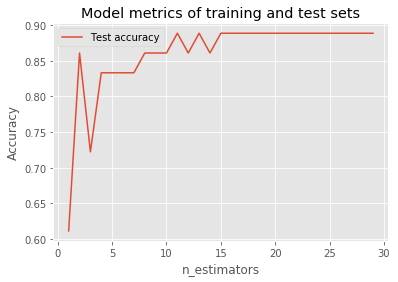

In [23]:
training_accuracy = []
test_accuracy = []

estimators = range(1, 30)

for estimator_idx in estimators:
    # Create adaboost classifer object
    adaboost = AdaBoostClassifier(n_estimators = estimator_idx, learning_rate = 1)
    # Train Adaboost Classifer
    model = adaboost.fit(x_train, y_train)
    #Predict the response for test dataset
    y_pred = model.predict(x_test)
    
    # se almacena la "generalization accuracy"
    test_accuracy.append(metrics.accuracy_score(y_test, y_pred))

# Plot results
plt.plot(estimators, test_accuracy, label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.title("Model metrics of training and test sets")
plt.legend()

En este caso se observa que después de 15 estimadores el puntaje converge a 0.88 y no mejora después de ese punto.

Es posible además utilizar un estimador base diferente al estimador por defecto, que es DecisionTreeClassifier. Para este caso se utilizará Support Vector Machines y se iterará sobre 30 estimadores para determinar la convergencia del algoritmo.

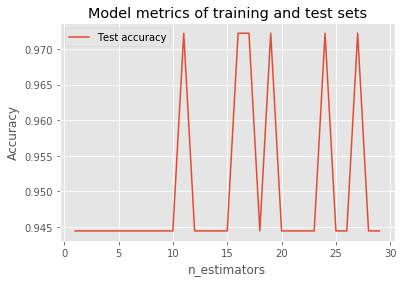

In [25]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier
# Import Support Vector Classifier
from sklearn.svm import SVC
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

svc = SVC(probability = True, kernel = 'linear', C=100.0, gamma=0.1)

training_accuracy = []
test_accuracy = []

estimators = range(1, 30)

for estimator_idx in estimators:
    # Create adaboost classifer object
    adaboost = AdaBoostClassifier(n_estimators = estimator_idx, base_estimator = svc, learning_rate = 1)
    # Train Adaboost Classifer
    model = adaboost.fit(x_train, y_train)
    #Predict the response for test dataset
    y_pred = model.predict(x_test)
    
    # se almacena la "generalization accuracy"
    test_accuracy.append(metrics.accuracy_score(y_test, y_pred))

# Plot results
plt.plot(estimators, test_accuracy, label="Test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_estimators")
plt.title("Model metrics of training and test sets")
plt.legend()

Se observa que la exactitud del modelo utilizando SVM mejoró con respecto a Decision Trees, donde se alcanza un puntaje entre 0.945 y 0.972.

# Resultados y Conclusiones

A continuación se brinda un resumen de los métodos probados junto con los puntajes obtenidos.

### kNN
Mejor puntaje: 0.777 

### kNN con datos escalados
Mejor puntaje: 0.972

### Regresión lineal
Mejor puntaje: 0.890 

### SVM kernel lineal
Mejor puntaje: 0.972

### SVM kernel polinomial
Mejor puntaje: 0.944 

### SVM kernel gaussiano
Mejor puntaje: 0.472 

### SVM kernel sigmoide
Mejor puntaje: 0.388 

### Decision trees
Mejor puntaje: 0.944

### LDA solucionador svm
Mejor puntaje: 1.000

### LDA solucionador lsqr
Mejor puntaje: 1.000

### LDA solucionador eigen
Mejor puntaje: 0.972

### Adaboost kernel lineal
Mejor puntaje: 0.972 

### Adaboost kernel decision tree
Mejor puntaje: 0.888 

De los resultados se observa que el algoritmo kNN brinda un rendimiento aceptable y este mejora cuando los datos se escalan. El algoritmo SVM se desempeña mejor para los *kernels* lineal y polinomial, y para el gaussiano y sigmoide el desempeño decae incluso a valores inaceptables. Los algoritmos de regresión lineal y decision tree brindan un desempeño alrededor del 90%. El algoritmo Adaboost se desempeña mejor con el kernel lineal que con el kernel de decision tree. El algoritmo LDA se desempeñó de manera perfecta para los solucionadores SVM y LSQR con un puntaje de 1.000, y con un puntaje de 0.972 para el solucionador con Eigenvalues.

Estos resultados nos indican que para el dataset elegido, se desempeñan mejor los algoritmos lineales y se verifica que los datos son linealmente separables.

# Referencias

[1] [Wine Data Set](https://archive.ics.uci.edu/ml/datasets/Wine)

[2] [Train/Test Split and Cross Validation in Python](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)

[3] [How to split your dataset to train and test datasets using SciKit Learn](https://medium.com/@contactsunny/how-to-split-your-dataset-to-train-and-test-datasets-using-scikit-learn-e7cf6eb5e0d)

[4] [Preprocessing in Data Science (Part 1): Centering, Scaling, and KNN](https://www.datacamp.com/community/tutorials/preprocessing-in-data-science-part-1-centering-scaling-and-knn)

[5] [Supervised Learning Examples](https://github.com/fmezacr/patrones/blob/master/Supervised_Learning_Examples.ipynb)

[6] [Simple and Multiple Linear Regression in Python](https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9)

[7] [Classification Accuracy is Not Enough: More Performance Measures You Can Use](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/)

[8] [AdaBoost Classifier in Python](https://www.datacamp.com/community/tutorials/adaboost-classifier-python)

[9] [Implementing SVM and Kernel SVM with Python's Scikit-Learn](https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/)

[10] [RBF SVM parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)

[11] [Decision Tree classification Python](https://www.datacamp.com/community/tutorials/decision-tree-classification-python)

[12] [Classification — Linear Discriminant Analysis](https://towardsdatascience.com/classification-part-2-linear-discriminant-analysis-ea60c45b9ee5)
